In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords # Import the stop word list


import math
import json
import csv
from collections import Counter

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neural_network
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

# Load Data #

* We have selected 10 individuals who are business or social celebrities.

* They are each extremely popular on Twitter and have tens of millions of followers.

In [2]:
elonmusk = pd.read_csv('../data/elonmusk_tweets.csv')
NASA = pd.read_csv('../data/NASA_tweets.csv')
nytimes = pd.read_csv('../data/nytimes_tweets.csv')
espn = pd.read_csv('../data/espn_tweets.csv')
JamesWoods = pd.read_csv('../data/RealJamesWoods_tweets.csv')
katyperry = pd.read_csv('../data/katyperry_tweets.csv')
ScottAdams = pd.read_csv('../data/ScottAdamsSays_tweets.csv')
WilliamShatner = pd.read_csv('../data/WilliamShatner_tweets.csv')
tim_cook = pd.read_csv('../data/tim_cook_tweets.csv')
BillGates = pd.read_csv('../data/BillGates_tweets.csv')

In [27]:
ScottAdams.head()

,text,author
0,biased hater like yourself evidently,ScottAdamsSays
1,rarely does any one variable explain this sort...,ScottAdamsSays
2,the vulnerable population is unknown because n...,ScottAdamsSays
3,thanks for noticing,ScottAdamsSays
4,these studies don t address my point that it m...,ScottAdamsSays


# Tokenizer #

* Step 1 - Call Beautiful Soup to clean out HTML fragments in tweets.

* Step 2 - Strip url's and keep only letters and numbers

* Step 3 - Strip out utf-8 tags

* Step 4 - Lower case and tokenize

In [3]:

tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def clean_tweet(raw_tweet):
    # 1. Remove HTML
    soup = BeautifulSoup(raw_tweet)
    souped = soup.get_text()
    #
    # 2. Remove non-letters        
    #letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    #
    # 3. Convert to lower case, split into individual words
    lower_case = letters_only.lower()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    #stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    #meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    #return( " ".join( meaningful_words ))   
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()
    

In [5]:
tweeters = [elonmusk,NASA,nytimes,espn,JamesWoods,katyperry,ScottAdams,WilliamShatner,tim_cook,BillGates]
for item in tweeters:
    for i in range(len(item)):
        item['text'][i] = clean_tweet(item['text'][i])

In [6]:
BillGates[:17]

,text,author
0,at smarter advising is helping students go fur...,BillGates
1,glad to see this story told i m always inspire...,BillGates
2,in the early days of microsoft i felt pretty c...,BillGates
3,france has been a leading champion in the figh...,BillGates
4,i recently caught a glimpse at the future of h...,BillGates
5,my visit to made me wish i could be a college ...,BillGates
6,exciting to see how digital tech combined with...,BillGates
7,dollar street is a beautiful reminder that we ...,BillGates
8,rt wants to thankateacher michaela raikes an i...,BillGates
9,cat ladies are everywhere nearly everyone has ...,BillGates


In [7]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
count_vect = CountVectorizer()

In [8]:
total_data =  pd.concat(tweeters)

In [9]:
total_data.tail()

,text,author
2510,my new website is live check out www thegatesn...,BillGates
2511,many people are asking how hey can help in hai...,BillGates
2512,thanks to you and all the other people who hav...,BillGates
2513,thanks for your work on this it will have a re...,BillGates
2514,hello world hard at work on my foundation lett...,BillGates


In [10]:
total_data.head()

,text,author
0,s yes,elonmusk
1,exactly,elonmusk
2,they can form a union whenever they want there...,elonmusk
3,upgrade to the latest s nothing will give you ...,elonmusk
4,soto they are correct it s awesome second best...,elonmusk


In [12]:
X = total_data.drop(['author'])
y = total_data['author']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
train_data_bow = count_vect.fit_transform(X_train['text'])
test_data_bow = count_vect.transform(X_test['text'])

In [15]:
tfid_vect = TfidfVectorizer()

In [16]:
train_data_tfid = tfid_vect.fit_transform(X_train['text'])

test_data_tfid = tfid_vect.transform(X_test['text'])

In [17]:
train_data_tfid.shape

(19118, 19920)

In [18]:
rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, train_data_bow, y_train, cv=10)

array([0.46398747, 0.48956159, 0.46969697, 0.45924765, 0.48771563,
       0.47646444, 0.48638743, 0.47012579, 0.4769392 , 0.47561615])

In [19]:
lr = LogisticRegression()
cross_val_score(lr, train_data_bow, y_train, cv=10)

array([0.69467641, 0.68528184, 0.68599791, 0.68129572, 0.69942499,
       0.68305439, 0.70052356, 0.68658281, 0.70178197, 0.67960147])

# Experiment with Bigrams #

In [20]:
count_vect_bigram = CountVectorizer(ngram_range=(1,2))
train_data_bow_bigram = count_vect_bigram.fit_transform(X_train['text'])
test_data_bow_bigram = count_vect_bigram.transform(X_test['text'])

In [21]:
cross_val_score(lr, train_data_bow_bigram, y_train, cv=10)

array([0.69206681, 0.69258873, 0.69017764, 0.68913271, 0.71092525,
       0.68985356, 0.69685864, 0.68343816, 0.68867925, 0.68589407])

In [28]:
ats = ['elonmusk','NASA','nytimes','espn','RealJamesWoods','katyperry','ScottAdamsSays','WilliamShatner','tim_cook','BillGates']

* Bigrams do not appear to be especially effective.

* As they do not specifically hurt performance, they will still be used.

# Confusion Matrix #


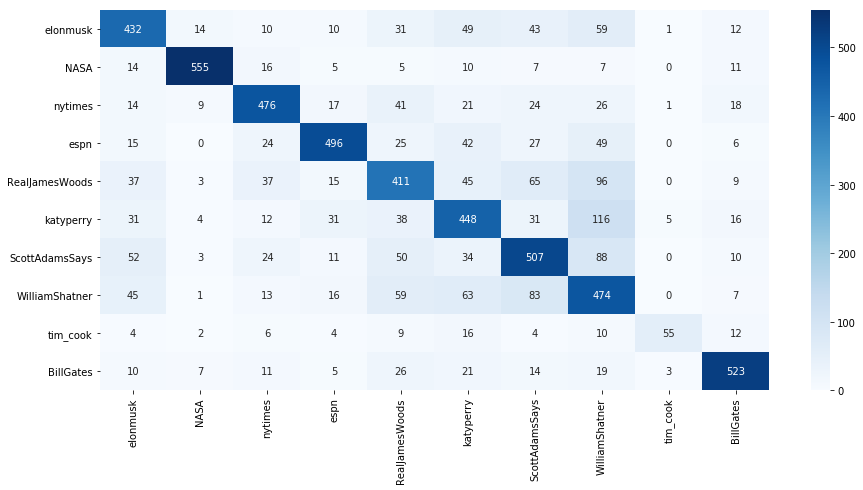

In [29]:
#Confusion matrix for Bigram BOG with Logistic Regression

lr = LogisticRegression()
lr.fit(train_data_bow_bigram,y_train)


y_pred = lr.predict(test_data_bow_bigram)

conf = confusion_matrix(y_test, y_pred, labels = ats)

cm = pd.DataFrame(conf, index = [i for i in ats],
                  columns = [i for i in ats])
plt.figure(figsize = (15,7))
sns.heatmap(cm, annot=True, cmap="Blues", fmt = 'd')